In [1]:
import hoomd
from hoomd import hpmc

In [2]:
hoomd.context.initialize('')

HOOMD-blue 2.9.6 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 03/17/2021
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
HOOMD-blue is running on the CPU


In [3]:
box = hoomd.data.boxdim(L=10,dimensions=2)
snap = hoomd.data.make_snapshot(N=64,particle_types=['A'],box=box)
snap.particles.position[:] = [(i,j,0) for i in range(-4,4) for j in range(-4,4)]

In [4]:
system = hoomd.init.read_snapshot(snap)

notice(2): Group "all" created containing 64 particles


In [5]:
mc = hpmc.integrate.sphere(seed=123)

In [6]:
sigma=1
mc.shape_param.set('A',diameter=sigma)

In [7]:
gsd = hoomd.dump.gsd('trajectory.gsd',period=10,group=hoomd.group.all(),overwrite=True)

In [8]:
mc.set_params(d=0.1)

In [9]:
hoomd.run(10000)

** starting run **
Time 00:00:02 | Step 10000 / 10000 | TPS 11017.6 | ETA 00:00:00
Average TPS: 11009
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.769196
notice(2): Trial moves per second:        2.81618e+06
notice(2): Overlap checks per second:     5.52829e+07
notice(2): Overlap checks per trial move: 19.6305
notice(2): Number of overlap errors:      0
** run complete **


In [10]:
snap = system.take_snapshot()

In [11]:
def plot_config(pts):
    fig, ax = plt.subplots()
    fig.set_size_inches(5,5)
    circles = [plt.Circle(p,.5) for p in pts]
    for c in circles:
        ax.add_patch(c)
    ax.set_xlim(-system.box.Lx/2,system.box.Lx/2)
    ax.set_ylim(-system.box.Ly/2,system.box.Ly/2)

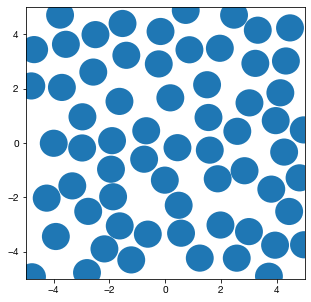

In [12]:
import matplotlib.pyplot as plt
pts = snap.particles.position[:]
plot_config(pts)

### Invertible network for hard particles

In [13]:
# Maximum likelihood in z
import tensorflow as tf
class LossML(tf.keras.losses.Loss):
    def __init__(self, inv_net, std=1.0):
        self.std = std
        self.inv_net = inv_net
        super().__init__()
        
    def call(self, y_true, y_pred):
        return -self.inv_net.log_likelihood_z_normal(std=self.std)

In [370]:
# Maximum likelihood in z
import tensorflow as tf
class LossConfiguration(tf.keras.losses.Loss):
    def __init__(self, inv_net):
        self.inv_net = inv_net
        super().__init__()
        
    def call(self, y_true, y_pred):
        x = self.inv_net.output_x
        f = self.inv_net.overlap_model.smooth_overlap_tf(x)
        #return f-self.inv_net.log_det_Jzx[:,0]
        return tf.math.log(f)-self.inv_net.log_det_Jzx[:,0]

In [371]:
import tensorflow.keras as keras
import tensorflow as tf
from deep_boltzmann.networks.invertible import InvNet

class OverlapInvNet(InvNet):

    def __init__(self, overlap_model, layers):
        """ Invertible net where we have an overlap function (==0 or 1) that defines p(x)
            and the prior is the uniform on the interval [a,b)"""
        self.overlap_model = overlap_model
        super().__init__(overlap_model.dim, layers, prior='normal')
        

#        self.Tzx.add_loss(weighted_KL_loss)

    @classmethod
    def load(cls, filename, energy_model):
        """ Loads parameters into model. Careful: this clears the whole TF session!!
        """
        from deep_boltzmann.util import load_obj
        keras.backend.clear_session()
        D = load_obj(filename)
        layerdicts = D['layers']
        layers = [eval(d['type']).from_dict(d) for d in layerdicts]
        return EnergyInvNet(energy_model, layers, prior=prior)

    def weight(self):
        """ Computes the reweighting factor
        """
        z = self.input_z
        x = self.output_x
        # compute z energy
        Ez = self.dim * tf.log(b-a)
        # compute overlap property
        f = self.overlap_model.overlap_tf(x)
        weight = (1-f)*tf.math.exp(Ez)*tf.math.exp(self.log_det_Jzx[:, 0])
        return weight

    def sample(self, nsample=100000):
        """ Samples from prior distribution in z and produces generated x configurations

        Parameters:
        -----------
        temperature : float
            Relative temperature. Equal to the variance of the isotropic Gaussian sampled in z-space.
        nsample : int
            Number of samples

        Returns:
        --------
        sample_z : array
            Samples in z-space
        sample_x : array
            Samples in x-space
        weight_z:
            Weight of z samples
        overlap_x : array
            Overlap property of x samples
        w : array
            Weight of samples

        """
        sample_z, energy_z = self.sample_z(nsample=nsample, return_energy=True)
        sample_x, Jzx = self.transform_zxJ(sample_z)
        overlap_x = self.overlap_model.overlap(sample_x)
        w = (1-overlap_x) * np.exp(energy_z) * np.exp(Jzx)

        return sample_z, sample_x, np.exp(-energy_z), overlap_x, w

    
    def train_z(self, x, xval=None, optimizer=None, lr=0.001, epochs=2000, batch_size=1024, verbose=1, clipnorm=None):
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.Adam(lr=lr)
            else:
                optimizer = keras.optimizers.Adam(lr=lr, clipnorm=clipnorm)
                
        self.Txz.compile(optimizer, loss=LossML(self))

        if xval is not None:
            validation_data = (xval, np.zeros_like(xval))
        else:
            validation_data = None


        hist = self.Txz.fit(x=x, y=x, validation_data=validation_data,
                            batch_size=batch_size, epochs=epochs, verbose=verbose, shuffle=True)

        return hist
    
    def train_x(self, optimizer=None, lr=0.001, epochs=2000, batch_size=1024, verbose=1, clipnorm=None):
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.Adam(lr=lr)
            else:
                optimizer = keras.optimizers.Adam(lr=lr, clipnorm=clipnorm)
                
        self.Tzx.compile(optimizer, loss=LossConfiguration(self))

        x = self.sample_z(nsample=epochs*batch_size, return_energy=False)
        hist = self.Tzx.fit(x=x, y=x, batch_size=batch_size, epochs=epochs, verbose=verbose, shuffle=True)

        return hist

    def train_both(self, x, xval=None, optimizer=None, lr=0.001, epochs=2000, batch_size=1024, verbose=1, clipnorm=None):
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.Adam(lr=lr)
            else:
                optimizer = keras.optimizers.Adam(lr=lr, clipnorm=clipnorm)
       
        inputs = []
        outputs = []
        losses = []
        losses.append(LossML(self))
        losses.append(LossConfiguration(self))
        inputs.append(self.input_x)
        inputs.append(self.input_z)
        outputs.append(self.output_z)
        outputs.append(self.output_x)

        self.model = keras.models.Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=optimizer,loss=losses,loss_weights=[1,1])
        
        if xval is not None:
            validation_data = (xval, np.zeros_like(xval))
        else:
            validation_data = None

        w = self.sample_z(nsample=x.shape[0], return_energy=False)
        hist = self.model.fit(x=[x,w], y=[x,w], validation_data=validation_data,
                            batch_size=batch_size, epochs=epochs, verbose=verbose, shuffle=True)

        return hist

In [372]:
from deep_boltzmann.networks.invertible import split_merge_indices, SplitChannels, MergeChannels, \
                                               RealNVP, InvNet, nonlinear_transform

def invnet(dim, layer_types, overlap_model=None, channels=None,
           nl_layers=2, nl_hidden=100, nl_activation='relu', scale=None, prior='normal'):
    """
    layer_types : str
        String describing the sequence of layers. Usage:
            N NICER layer
            R RealNVP layerl
            S Scaling layer
        Splitting and merging layers will be added automatically
    overlap_model : Overlap model class
        Class with overlap_tf() and dim
    channels : array or None
        Assignment of dimensions to channels (0/1 array of length ndim)
    nl_layers : int
        Number of hidden layers in the nonlinear transformations
    nl_hidden : int
        Number of hidden units in each nonlinear layer
    nl_activation : str
        Activation functions used in the nonlinear layers
    scale : None or float
        If a scaling layer is used, fix the scale to this number. If None, scaling layers are trainable
    """
    # fix channels
    channels, indices_split, indices_merge = split_merge_indices(dim, nchannels=2, channels=channels)

    # augment layer types with split and merge layers
    split = False
    tmp = ''
    for ltype in layer_types:
        if ltype == 'S' and split:
            tmp += '>'
            split = False
        if (ltype == 'N' or ltype == 'R') and not split:
            tmp += '<'
            split = True
        tmp += ltype
    if split:
        tmp += '>'
    layer_types = tmp
    print(layer_types)

    # prepare layers
    layers = []

    reg = tf.keras.regularizers.l2(10) #?
    reg = None
    for ltype in layer_types:
        if ltype == '<':
            # split into two x channels
            layers.append(SplitChannels(dim, nchannels=2, channels=channels))
        if ltype == '>':
            # merge into one z channel
            layers.append(MergeChannels(dim, nchannels=2, channels=channels))
        if ltype == 'N':
            M1 = nonlinear_transform(indices_split[1].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation)
            M2 = nonlinear_transform(indices_split[0].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation)
            layers.append(NICER([M1, M2]))
        elif ltype == 'R':
            S1 = nonlinear_transform(indices_split[1].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation, init_outputs=0,
                                     activity_regularizer=reg)
            T1 = nonlinear_transform(indices_split[1].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation,
                                     activity_regularizer=reg)
            S2 = nonlinear_transform(indices_split[0].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation, init_outputs=0,
                                     activity_regularizer=reg)
            T2 = nonlinear_transform(indices_split[0].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation,
                                     activity_regularizer=reg)
            layers.append(RealNVP([S1, T1, S2, T2]))
        elif ltype == 'S':
            # scaling layer
            if scale is None:
                scaling_factors = None
            else:
                scaling_factors = scale * np.ones((1, dim))
            layers.append(Scaling(dim, scaling_factors=scaling_factors, trainable=(scale is None)))

    if overlap_model is None:
        inv_net = InvNet(dim, layers, prior='normal')
    else:
        inv_net = OverlapInvNet(overlap_model, layers)
    
    inv_net.reg = reg
    return inv_net

### Hard disk overlap

In [398]:
import numpy as np

def ensure_traj(X):
    if np.ndim(X) == 2:
        return X
    if np.ndim(X) == 1:
        return np.array([X])
    raise ValueError('Incompatible array with shape: ', np.shape(X))

    
def dist2_min_image(crd1, crd2, L, dim=2):
    """ Returns the distance matrix or matrices between particles, with periodic boundary conditions

    Parameters
    ----------
    crd1 : array or matrix
        first coordinate set
    crd2 : array or matrix
        second coordinate set
    L: length of simulation box
    dim : int
        dimension of particle system. If d=2, coordinate vectors are [x1, y1, x2, y2, ...]

    """
    crd1 = ensure_traj(crd1)
    crd2 = ensure_traj(crd2)
    n = int(np.shape(crd1)[1]/dim)

    crd1_components = [np.tile(np.expand_dims(crd1[:, i::dim], 2), (1, 1, n)) for i in range(dim)]
    crd2_components = [np.tile(np.expand_dims(crd2[:, i::dim], 2), (1, 1, n)) for i in range(dim)]
    
    dr_components = np.array([(crd1_components[i] - np.transpose(crd2_components[i], axes=(0, 2, 1))) for i in range(dim)])
    
    # minimum image
    D2_components = dr_components - L*((dr_components+0.5*L)//L)
    D2_components = D2_components**2
    D2 = np.sum(D2_components, axis=0)
    return D2

class HardDisks(object):
    def __init__(self,N, L,sigma,eps=1):
        """ N: number of particles
            L: Box length
            sigma: Particle size"""
        self.N = N
        self.dim = 2*self.N # dim = 2
        self.L = L
        self.sigma = sigma
        self.mask_matrix = np.ones((self.N, self.N), dtype=np.float32)
        for i in range(self.N):
            self.mask_matrix[i, i] = 0.0
        self.eps=eps

    def wrap(self, x):
        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]        
        xcomp -= ((xcomp+0.5*self.L)//self.L)*self.L
        ycomp -= ((ycomp+0.5*self.L)//self.L)*self.L
        out = np.zeros(shape=x.shape)
        out[:,0::2] = xcomp
        out[:,1::2] = ycomp
        return out
    
    def overlap(self, x):
        # all pairwise distances
        batchsize = np.shape(x)[0]
        D2 = dist2_min_image(x, x, self.L)
        mmatrix = np.tile(np.expand_dims(self.mask_matrix, 0), (batchsize, 1, 1))
        
        # remove self-interactions
        D2rel = D2 * mmatrix
        
        # overlap
        f = np.max(np.where(D2rel<sigma*sigma,1.0,0.0), axis=(1, 2))
        return f
    
    def overlap_tf(self, x):

        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]
        batchsize = tf.shape(x)[0]
        n = tf.shape(xcomp)[1]
        Xcomp = tf.tile(tf.expand_dims(xcomp, 2), [1, 1, n])
        Ycomp = tf.tile(tf.expand_dims(ycomp, 2), [1, 1, n])
        Dx = Xcomp - tf.transpose(Xcomp, perm=[0, 2, 1])
        Dy = Ycomp - tf.transpose(Ycomp, perm=[0, 2, 1])

        # minimum image
        Dx = Dx-tf.math.floordiv(Dx+0.5*self.L,self.L)*self.L
        Dy = Dy-tf.math.floordiv(Dy+0.5*self.L,self.L)*self.L
        D2 = Dx**2 + Dy**2

        mmatrix = tf.tile(tf.expand_dims(self.mask_matrix, 0), [batchsize, 1, 1])

        return tf.reduce_max(tf.where((D2<sigma*sigma),
                                      mmatrix*tf.ones_like(D2),tf.zeros_like(D2)),
                             axis=(1, 2))
    
    def smooth_overlap_tf(self, x):

        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]
        batchsize = tf.shape(x)[0]
        n = tf.shape(xcomp)[1]
        Xcomp = tf.tile(tf.expand_dims(xcomp, 2), [1, 1, n])
        Ycomp = tf.tile(tf.expand_dims(ycomp, 2), [1, 1, n])
        Dx = Xcomp - tf.transpose(Xcomp, perm=[0, 2, 1])
        Dy = Ycomp - tf.transpose(Ycomp, perm=[0, 2, 1])

        # minimum image
        Dx = Dx-tf.math.floordiv(Dx+0.5*self.L,self.L)*self.L
        Dy = Dy-tf.math.floordiv(Dy+0.5*self.L,self.L)*self.L
        D2 = Dx**2 + Dy**2

        mmatrix = tf.tile(tf.expand_dims(self.mask_matrix, 0), [batchsize, 1, 1])

        return tf.reduce_sum(tf.nn.relu(self.eps*mmatrix*(sigma*sigma-D2)), axis=(1, 2))

### Create the model

In [416]:
model = HardDisks(N=snap.particles.N,
                  L=snap.box.Lx,
                  sigma=sigma,
                  eps=10)

In [417]:
import gsd.hoomd

In [418]:
f = gsd.hoomd.open(name='trajectory.gsd', mode='rb')

In [419]:
# flatten trajectory in last dimension (d=2)
Xtrain = np.stack([fi.particles.position for fi in f])[:,:,:2].reshape((len(f),-1))

In [420]:
Xtrain.shape

(1000, 128)

In [421]:
batchsize = 100

### Train with the linear combination of two loss functions

In [422]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [423]:
# reset model
bg = invnet(model.dim, 'RRRRRRRR', overlap_model=model, nl_layers=4, nl_hidden=200, #100
           nl_activation='tanh')


<RRRRRRRR>


In [424]:
hist_bg = bg.train_both(Xtrain,epochs=100,lr=0.001,batch_size=batchsize)

Train on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 5s 5ms/sample - loss: 219.3890 - output_z_loss: 250.9506 - output_x_loss: -31.5616
Epoch 2/100
1000/1000 [==============================] - 1s 653us/sample - loss: -266.2993 - output_z_loss: 176.9805 - output_x_loss: -443.2797
Epoch 3/100
1000/1000 [==============================] - 1s 666us/sample - loss: -377.9591 - output_z_loss: 250.3538 - output_x_loss: -628.3129
Epoch 4/100
1000/1000 [==============================] - 1s 646us/sample - loss: -40.5813 - output_z_loss: 430.9182 - output_x_loss: -471.4996
Epoch 5/100
1000/1000 [==============================] - 1s 668us/sample - loss: 257.9083 - output_z_loss: 582.7264 - output_x_loss: -324.8181
Epoch 6/100
1000/1000 [==============================] - 1s 657us/sample - loss: 402.7785 - output_z_loss: 638.6469 - output_x_loss: -235.8684
Epoch 7/100
1000/1000 [==============================] - 1s 675us/sample - loss: 837.2171 - output_z_loss: 890.8600 - out

1000/1000 [==============================] - 1s 677us/sample - loss: nan - output_z_loss: nan - output_x_loss: nan
Epoch 59/100
1000/1000 [==============================] - 1s 665us/sample - loss: nan - output_z_loss: nan - output_x_loss: nan
Epoch 60/100
1000/1000 [==============================] - 1s 652us/sample - loss: nan - output_z_loss: nan - output_x_loss: nan
Epoch 61/100
1000/1000 [==============================] - 1s 697us/sample - loss: nan - output_z_loss: nan - output_x_loss: nan
Epoch 62/100
1000/1000 [==============================] - 1s 664us/sample - loss: nan - output_z_loss: nan - output_x_loss: nan
Epoch 63/100
1000/1000 [==============================] - 1s 669us/sample - loss: nan - output_z_loss: nan - output_x_loss: nan
Epoch 64/100
1000/1000 [==============================] - 1s 664us/sample - loss: nan - output_z_loss: nan - output_x_loss: nan
Epoch 65/100
1000/1000 [==============================] - 1s 692us/sample - loss: nan - output_z_loss: nan - output_x

KeyboardInterrupt: 

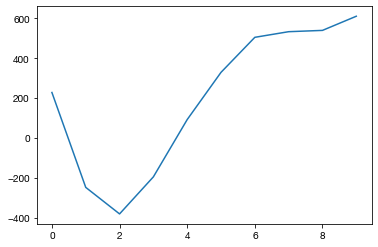

In [410]:
fig, ax = plt.subplots()
ax.plot(hist_bg.history['loss'])

In [411]:
print(tf.__version__)

2.4.0


In [412]:
_, sample_x, _, overlap_x, _ = bg.sample(nsample=100)

/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in exp
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in multiply


In [ ]:
plot_config(model.wrap(sample_x)[0:1].reshape(-1,2))

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

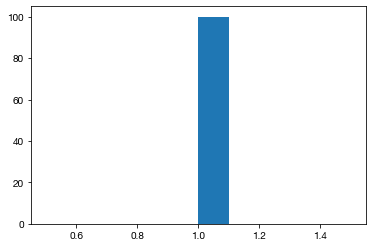

In [414]:
fig, ax = plt.subplots()
ax.hist(overlap_x)